In [ ]:
!git clone https://github.com/mertkslkc/bulutbilisimkampi.git

fatal: destination path 'bulutbilisimkampi' already exists and is not an empty directory.


In [ ]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from numpy.ma.core import size
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt

np.random.seed(1)
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.8.2


In [ ]:
df = pd.read_csv('/content/bulutbilisimkampi/cpu_utilizations.csv',sep=';')
df.head()

,datetime,cpu_usage
0,Sat Sep 10 2022 20:00:00 GMT+0300 (GMT+03:00),0.045620
1,Sat Sep 10 2022 21:00:00 GMT+0300 (GMT+03:00),0.046803
2,Sat Sep 10 2022 22:00:00 GMT+0300 (GMT+03:00),0.047473
3,Sat Sep 10 2022 23:00:00 GMT+0300 (GMT+03:00),0.044281
4,Sun Sep 11 2022 00:00:00 GMT+0300 (GMT+03:00),0.056652


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['datetime'], y=df['cpu_usage'], name='CPU Değeri'))
fig.update_layout(showlegend=True, title='CPU Kullanımı Genel Grafik')
fig.show()

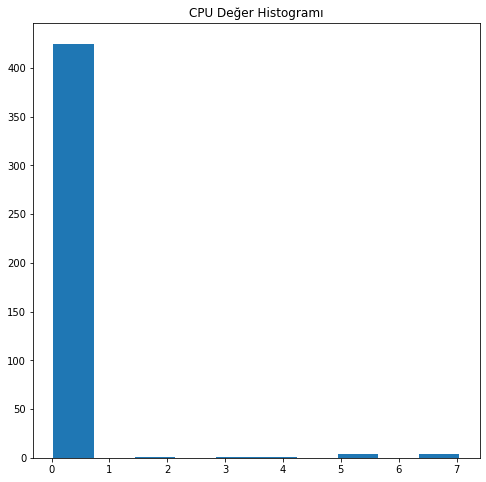

In [ ]:
plt.figure(figsize=(8,8))
plt.hist(df['cpu_usage'])
plt.title("CPU Değer Histogramı")
plt.show()

In [ ]:
train, test= train_test_split(df, test_size=0.20, shuffle=False)
print(f" Eğitim veri sayısı = {len(train)}", "\n", f"Test veri sayısı {len(test)}")

 Eğitim veri sayısı = 348 
 Test veri sayısı 88


In [ ]:
test

,datetime,cpu_usage
348,Sun Sep 26 2022 08:00:00 GMT+0300 (GMT+03:00),0.053625
349,Sun Sep 26 2022 09:00:00 GMT+0300 (GMT+03:00),0.046375
350,Sun Sep 26 2022 10:00:00 GMT+0300 (GMT+03:00),0.049485
351,Sun Sep 26 2022 11:00:00 GMT+0300 (GMT+03:00),0.060962
352,Sun Sep 26 2022 12:00:00 GMT+0300 (GMT+03:00),0.049546
...,...,...
431,Wed Sep 29 2022 19:00:00 GMT+0300 (GMT+03:00),0.057476
432,Wed Sep 29 2022 20:00:00 GMT+0300 (GMT+03:00),0.050241
433,Wed Sep 29 2022 21:00:00 GMT+0300 (GMT+03:00),0.048366
434,Wed Sep 29 2022 22:00:00 GMT+0300 (GMT+03:00),0.049914


In [ ]:
train.shape,test.shape

((348, 2), (88, 2))

In [ ]:
#scaler = StandardScaler()
#scaler = scaler.fit(train[['cpu_usage']])

#train['cpu_usage'] = scaler.transform(train[['cpu_usage']])
#test['cpu_usage'] = scaler.transform(test[['cpu_usage']])

In [ ]:
TIME_STEPS=12

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['cpu_usage']], train['cpu_usage'])
X_test, y_test = create_sequences(test[['cpu_usage']], test['cpu_usage'])

print(f'Training shape: {X_train.shape}')

print(f'Testing shape: {X_test.shape}')

Training shape: (336, 12, 1)
Testing shape: (76, 12, 1)


In [ ]:
X_train

array([[[0.04561955],
        [0.04680267],
        [0.0474732 ],
        ...,
        [0.05313765],
        [0.05793949],
        [0.04835983]],

       [[0.04680267],
        [0.0474732 ],
        [0.04428136],
        ...,
        [0.05793949],
        [0.04835983],
        [0.04902097]],

       [[0.0474732 ],
        [0.04428136],
        [0.05665199],
        ...,
        [0.04835983],
        [0.04902097],
        [0.04478052]],

       ...,

       [[0.05482136],
        [0.04926621],
        [0.05747617],
        ...,
        [0.04958967],
        [0.05073377],
        [0.05015199]],

       [[0.04926621],
        [0.05747617],
        [0.05024115],
        ...,
        [0.05073377],
        [0.05015199],
        [0.04896944]],

       [[0.05747617],
        [0.05024115],
        [0.04836576],
        ...,
        [0.05015199],
        [0.04896944],
        [0.06414023]]])

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.1))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.1))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_75 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_60 (Dropout)        (None, 128)               0         
                                                                 
 repeat_vector_30 (RepeatVec  (None, 12, 128)          0         
 tor)                                                            
                                                                 
 lstm_76 (LSTM)              (None, 12, 128)           131584    
                                                                 
 dropout_61 (Dropout)        (None, 12, 128)           0         
                                                                 
 time_distributed_30 (TimeDi  (None, 12, 1)            129       
 stributed)                                          

In [ ]:
history = model.fit(X_train, y_train, epochs=120, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/120
10/10 [==============================] - 59s 6s/step - loss: 0.1799 - val_loss: 0.0198
Epoch 2/120
10/10 [==============================] - 0s 35ms/step - loss: 0.1494 - val_loss: 0.0068
Epoch 3/120
10/10 [==============================] - 0s 35ms/step - loss: 0.1441 - val_loss: 0.0094
Epoch 4/120
10/10 [==============================] - 0s 35ms/step - loss: 0.1454 - val_loss: 0.0049
Epoch 5/120
10/10 [==============================] - 0s 36ms/step - loss: 0.1432 - val_loss: 0.0090
Epoch 6/120
10/10 [==============================] - 0s 34ms/step - loss: 0.1436 - val_loss: 0.0045
Epoch 7/120
10/10 [==============================] - 0s 36ms/step - loss: 0.1435 - val_loss: 0.0061
Epoch 8/120
10/10 [==============================] - 0s 37ms/step - loss: 0.1426 - val_loss: 0.0057
Epoch 9/120
10/10 [==============================] - 0s 35ms/step - loss: 0.1415 - val_loss: 0.0056


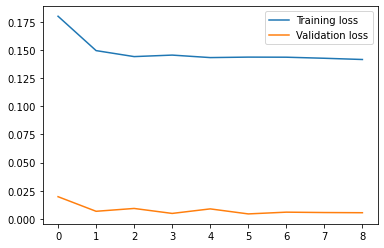

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [ ]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 10ms/step - loss: 0.2703


0.2703295648097992

Reconstruction error threshold: 3.2222247493582787


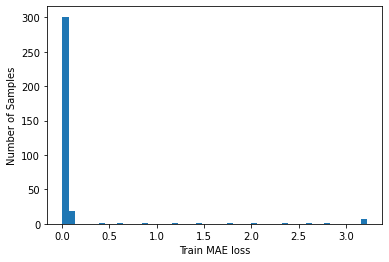

In [ ]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

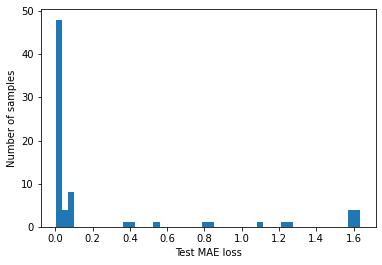

In [ ]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [ ]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['cpu_usage'] > test_score_df['threshold']
test_score_df['cpu_usage'] = test[TIME_STEPS:]['cpu_usage']

In [ ]:
test_score_df

,datetime,cpu_usage,loss,threshold,anomaly
360,Sun Sep 26 2022 20:00:00 GMT+0300 (GMT+03:00),0.063233,0.020701,3.222225,False
361,Sun Sep 26 2022 21:00:00 GMT+0300 (GMT+03:00),0.069022,0.021330,3.222225,False
362,Sun Sep 26 2022 22:00:00 GMT+0300 (GMT+03:00),4.067341,0.023226,3.222225,True
363,Sun Sep 26 2022 23:00:00 GMT+0300 (GMT+03:00),2.070340,0.366549,3.222225,False
364,Mon Sep 27 2022 00:00:00 GMT+0300 (GMT+03:00),3.056652,0.535103,3.222225,False
...,...,...,...,...,...
431,Wed Sep 29 2022 19:00:00 GMT+0300 (GMT+03:00),0.057476,0.004897,3.222225,False
432,Wed Sep 29 2022 20:00:00 GMT+0300 (GMT+03:00),0.050241,0.006140,3.222225,False
433,Wed Sep 29 2022 21:00:00 GMT+0300 (GMT+03:00),0.048366,0.005659,3.222225,False
434,Wed Sep 29 2022 22:00:00 GMT+0300 (GMT+03:00),0.049914,0.004524,3.222225,False


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['datetime'], y=test_score_df['cpu_usage'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['datetime'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [ ]:
anomalies = test_score_df[test_score_df['anomaly'] == True]
anomalies.head()

,datetime,cpu_usage,loss,threshold,anomaly
362,Sun Sep 26 2022 22:00:00 GMT+0300 (GMT+03:00),4.067341,0.023226,3.222225,True
365,Mon Sep 27 2022 01:00:00 GMT+0300 (GMT+03:00),5.043976,0.790302,3.222225,True
366,Mon Sep 27 2022 02:00:00 GMT+0300 (GMT+03:00),5.043599,1.215392,3.222225,True


In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=test_score_df['datetime'], y=(test_score_df['cpu_usage']), name='CPU Değeri'))
fig.add_trace(go.Scatter(x=anomalies['datetime'], y=(anomalies['cpu_usage']), mode='markers', name='Anormallik'))
fig.update_layout(showlegend=True, title='Algılanan Anormaller')
fig.show()